## Library loading

In [1]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
from scipy import sparse
from anndata import AnnData
import warnings
import socket
import plotly.express as px
from matplotlib import pylab
from matplotlib.colors import TwoSlopeNorm

import sys
import yaml
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles

warnings.filterwarnings('ignore')

In [2]:
import ipynbname
nb_fname = ipynbname.name()

In [3]:

FinaLeaf="/Progenitors"
ThreePointsDEGs = "./outdir/Progenitors/03B_Badhuri_Progenitors.3pointsModel.pBulk_byArea.scaled.DEGs.filtered.tsv"
CuratedListPath = "./data/resources/F_T.markers.scored.tsv"
outdir="./outdir"
adataPath = "./outdir/Progenitors/5B_Progenitors_pBulk.bySegment.10PRs.h5ad"
badhuriMarkers = ["PAX6","DDIT3","NEUROG2","CNBP","HMGB2","ZNF707","CAMTA1","SUB1","THYN1","NEUROG1","HMGB3","NFIX","BCL11A","TCF4","NR2F1"]
groupingCovariate = "regionContrast"
adataPathNowa = "./outdir/Progenitors/Badhuri_progenitors_pBulk.Curated.20PRs.bycortical_area.h5ad"

In [4]:
print(pd.read_csv(ThreePointsDEGs, sep = "\t", index_col=0).sort_values(by = "FWER", ascending = True).shape)


(255, 7)


In [5]:
%matplotlib inline

In [6]:
sc.settings.verbosity = 3         # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=50, facecolor='white')
pylab.rcParams['figure.figsize'] = (10, 10)


scanpy==1.8.1 anndata==0.7.6 umap==0.4.6 numpy==1.20.2 scipy==1.6.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


### Configure paths

In [7]:
hostRoot = "-".join(socket.gethostname().split('-')[0:2])

with open(os.path.expanduser('~')+"/paths_config.yaml", 'r') as f:
    paths = yaml.load(f, Loader=yaml.FullLoader)

#indir=paths["paths"]["indir"][hostRoot]
#projectBaseDir=paths["paths"]["projectBaseDir"][hostRoot]



In [8]:
CuratedList = pd.read_csv(CuratedListPath, sep = "\t", header=None, names=["gene","area","evidence"])


In [9]:
highConf =  CuratedList[CuratedList.evidence >= 2].gene.tolist()

## 3 points model DEGs

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=29
    finished (0:00:00)


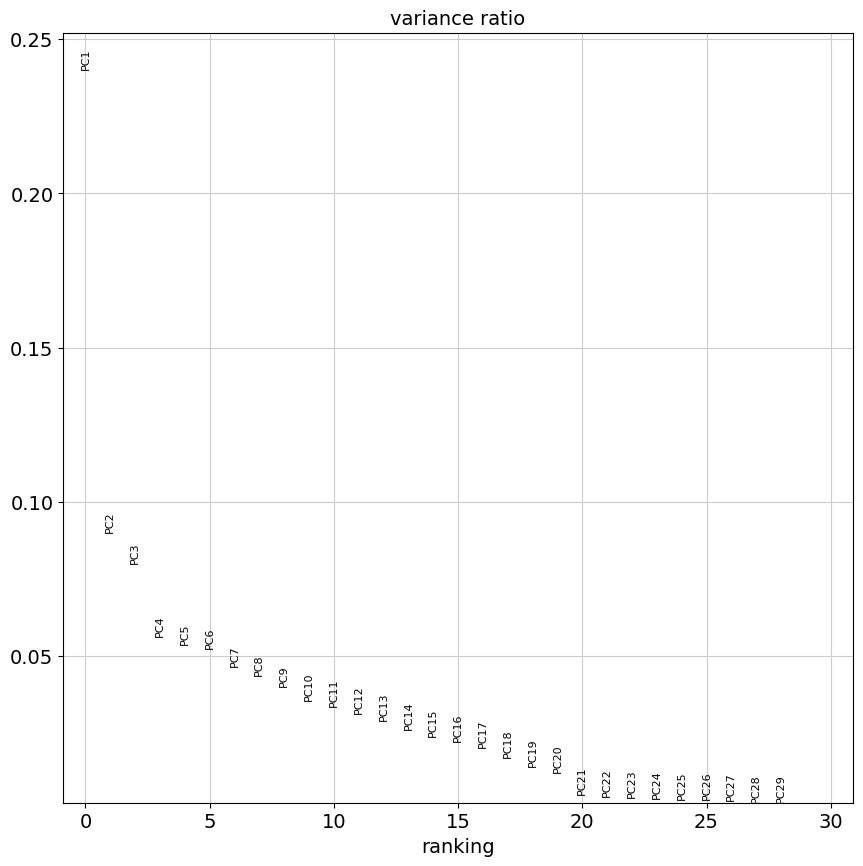

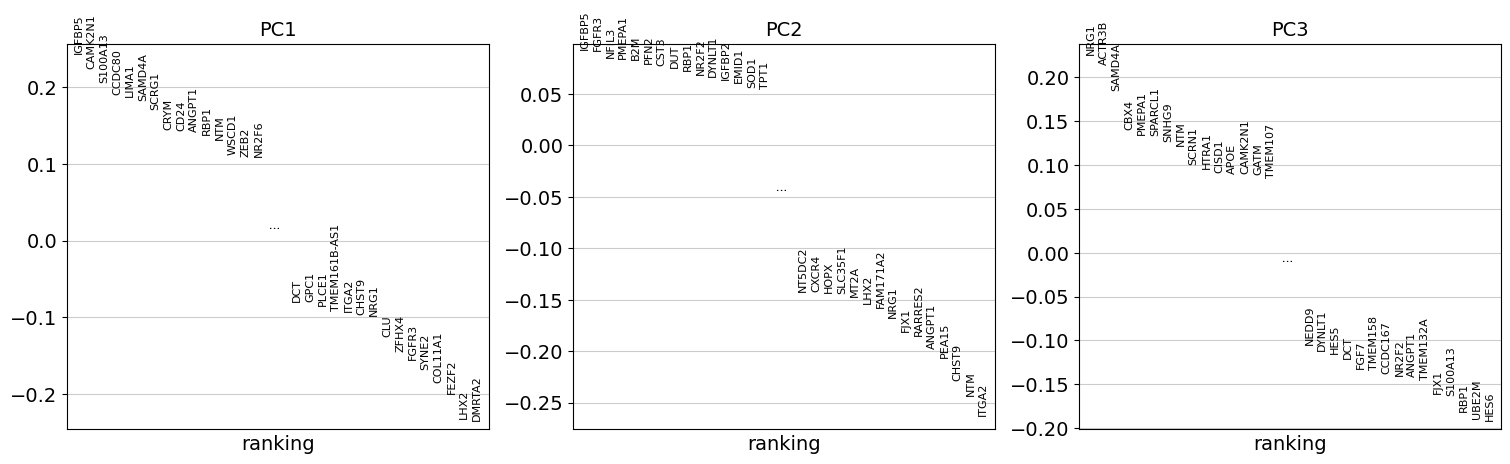

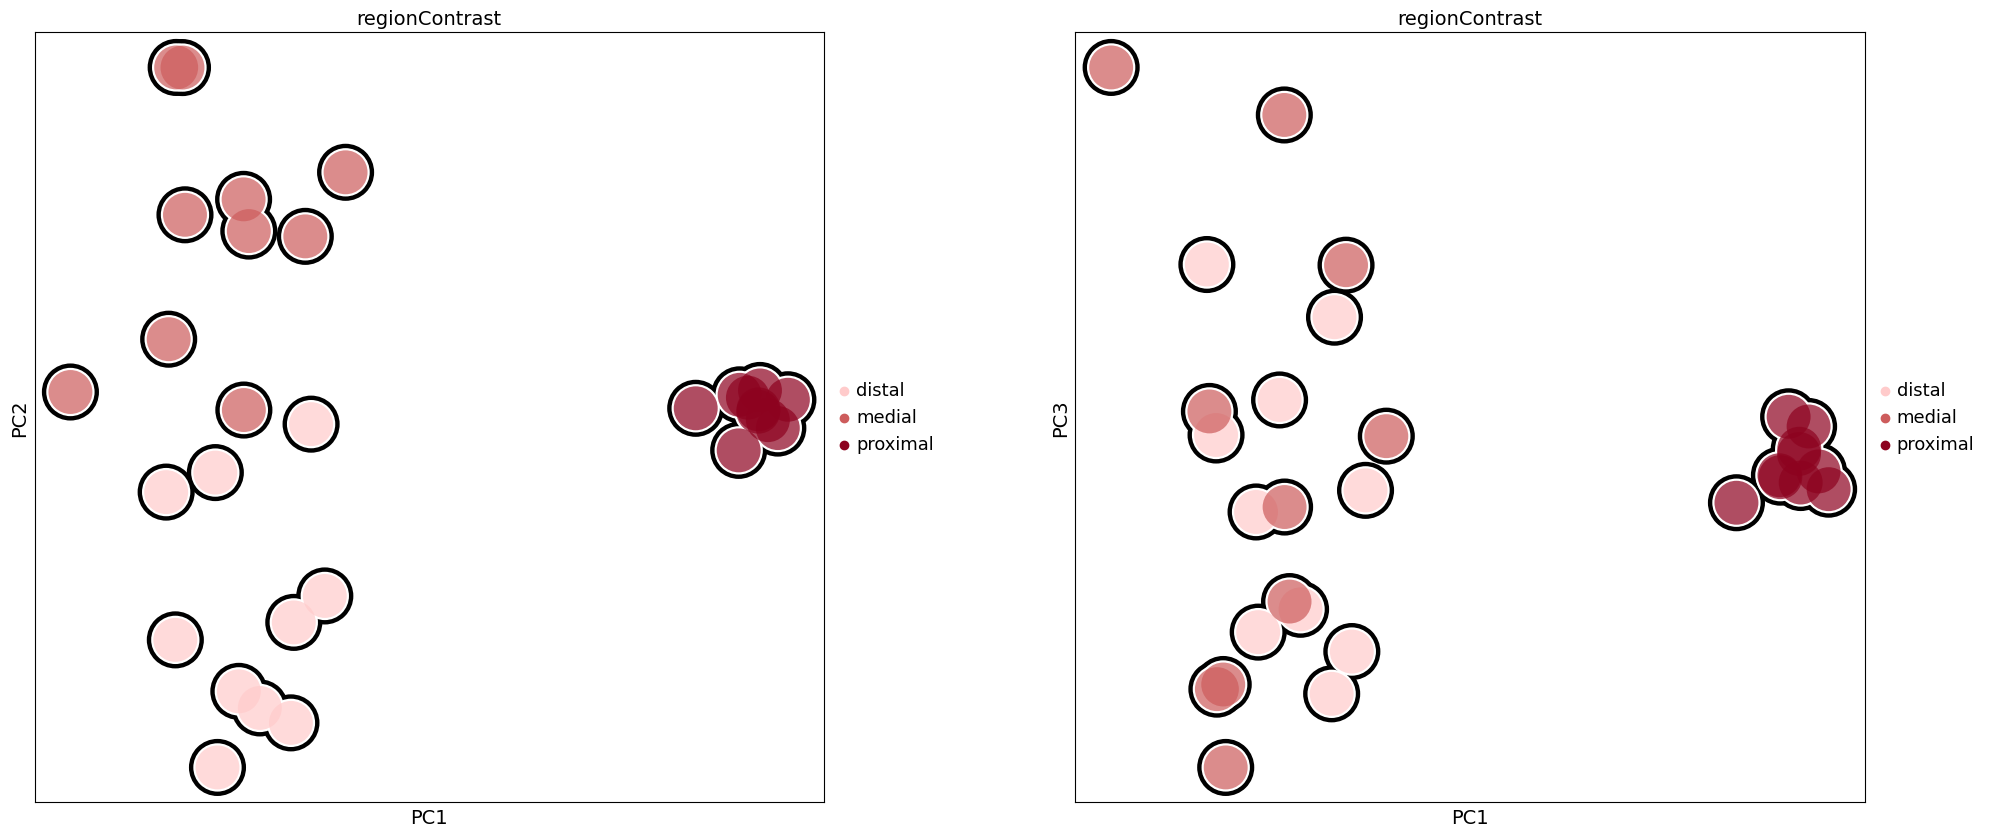

In [10]:

adata = sc.read_h5ad(adataPath)
adata=adata[adata.obs["type"] == "polaroid"]

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
NowaDEGs_3Points = pd.read_csv(ThreePointsDEGs, sep = "\t", index_col=0)
adata = adata[:,list(set(adata.var_names).intersection(NowaDEGs_3Points.index))]
#sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, use_highly_variable=False)

sc.pl.pca_variance_ratio(adata)

pylab.rcParams['figure.figsize'] = (6, 5)
sc.pl.pca_loadings(adata)

pylab.rcParams['figure.figsize'] = (10, 10)


#sc.pl.pca(adata, components=['1,2','1,3'], color=[groupingCovariate]+[m for m in highConf if m in adata.var_names.tolist()], ncols=2, add_outline=True, outline_width=(.1,.05), wspace=.2, show=False)
sc.pl.pca(adata, components=['1,2','1,3'], color=[groupingCovariate], ncols=2, add_outline=True, outline_width=(.1,.05), wspace=.2, show=False)


#store varm pca for later projection
loadings = adata.varm["PCs"]

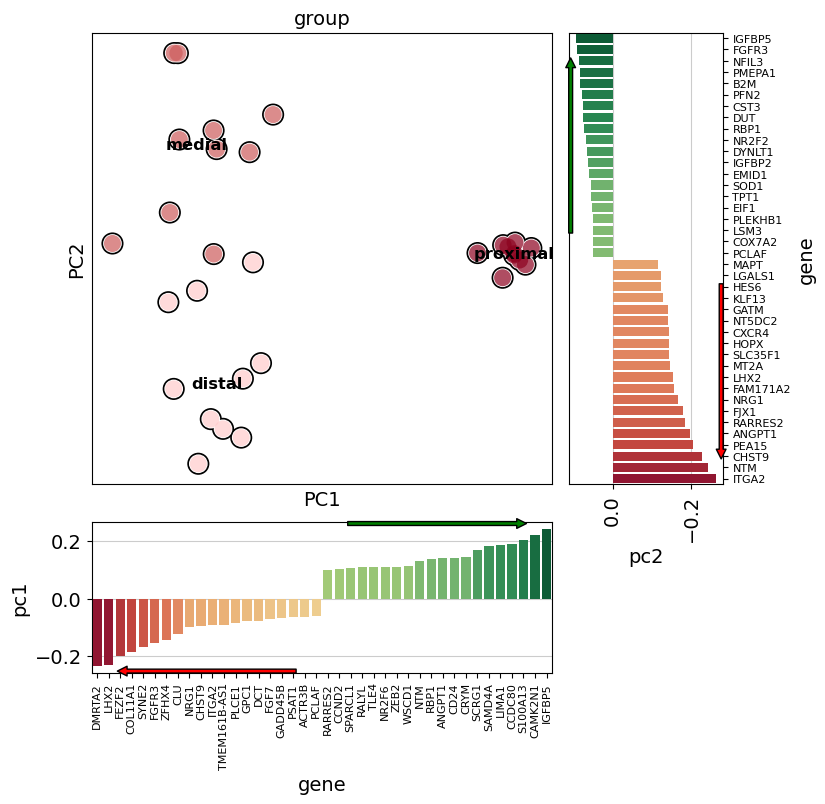

In [11]:
#if you want vector sc.settings._vector_friendly = False
vector=True
n=20
pdDict = {}
if vector:
    sc.settings._vector_friendly = False
for pc in  [0,1]:
    TopPC_IDX = np.argpartition(adata.varm["PCs"][:,pc], -n)[-n:]
    DownPC_IDX = np.argpartition(adata.varm["PCs"][:,pc], n)[:n]
    pdDict[pc] = pd.DataFrame(adata.varm["PCs"][:,pc][TopPC_IDX], index = adata.var_names[TopPC_IDX], columns=["pc"+str(pc+1)])
    pdDict[pc] = pd.concat([pdDict[pc],pd.DataFrame(adata.varm["PCs"][:,pc][DownPC_IDX], index = adata.var_names[DownPC_IDX], columns=["pc"+str(pc+1)])])
    pdDict[pc]["gene"] = pdDict[pc].index.tolist()
    if pc == 0:
        pdDict[pc] = pdDict[pc].sort_values("pc"+str(pc+1))
    elif pc == 1:
        pdDict[pc] = pdDict[pc].sort_values("pc"+str(pc+1), ascending = False)
    
    
    

figsize = (6, 6)  #(width, height)
#Set axes
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize,gridspec_kw={'width_ratios': [3, 1],'height_ratios': [3, 1]})

fig.tight_layout(pad=-2, h_pad=0)   #space between plots

ax1plot = sc.pl.pca(adata, components=['1,2'], color=["group"], 
                    ncols=1, add_outline=True, legend_loc="on data",size=600,legend_fontsize="small",
                    outline_width=(.1,.05), wspace=.2, show=False, ax=ax[0][0])



norm = TwoSlopeNorm(vmin=pdDict[0]["pc1"].min(), vcenter=0, vmax=pdDict[0]["pc1"].max())
colors = [plt.cm.RdYlGn(norm(c)) for c in pdDict[0]["pc1"]]
sns.barplot(data=pdDict[0], x="gene", y="pc1", color="pc1",palette=colors,ax=ax[1][0], zorder=3 ).tick_params(axis='x', rotation=90, labelsize=8)
ax[1][0].annotate("", xy=(.95,.99),xytext=(0.55, 0.99),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="green"))
ax[1][0].annotate("", xy=(.05,.01),xytext=(0.45, 0.01),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="red"))


norm = TwoSlopeNorm(vmin=pdDict[1]["pc2"].min(), vcenter=0, vmax=pdDict[1]["pc2"].max())
colors = [plt.cm.RdYlGn(norm(c)) for c in pdDict[1]["pc2"]]
sns.barplot(data=pdDict[1], x="pc2", y="gene", color="pc2",palette=colors,ax=ax[0][1], zorder=3 ).tick_params(axis='y',  
                                                                                                              labelsize=8, 
                                                                                                              labelright=True, labelleft=False,
                                                                                                              right=True, left=False)
ax[0][1].tick_params(axis='x', rotation=90)

ax[0][1].annotate("", xy=(.01,.95),xytext=(0.01, 0.55),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="green"))
ax[0][1].annotate("", xy=(.99,.05),xytext=(0.99, 0.45),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="red"))



ax[0][1].invert_xaxis()
ax[0][1].yaxis.set_label_position("right")
fig.delaxes(ax[1][1])

sc.settings._vector_friendly = True

In [12]:
import ipynbname
nb_fname = ipynbname.name()

In [13]:
fig.savefig("./figures/"+nb_fname+".PCA.pdf",
           bbox_inches="tight")